In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import kruskal

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set(style="whitegrid", font_scale=2.5)

### RQ1: What is the amount of search engine moderation on Google vs Baidu?

4 classes:
- consistent suggestion
- unresponded query
- no group in the suggestion
- changed format in the suggestion

1) Show top-10 groups consistent suggestions
2) 3 barplots for each of the other group

In [41]:
# Differences between template

In [70]:
# Read in the data
baidu = pd.read_csv("data/baidu.csv")
# baidu = baidu[baidu["template_match"] == "template 2"]
google = pd.read_csv("data/google.csv")

In [71]:
baidu['suggestion_starts_with_query'].fillna(False, inplace=True)
google['suggestion_starts_with_query'].fillna(False, inplace=True)
baidu_start_with_query = baidu[baidu['suggestion_starts_with_query']]
google_start_with_query = google[google['suggestion_starts_with_query']]
# remove duplicated data in the same group
baidu_start_with_query = baidu_start_with_query.drop_duplicates(subset=['group_English', 'completion'])
google_start_with_query = google_start_with_query.drop_duplicates(subset=['group', 'completion'])

In [77]:
baidu.drop_duplicates(subset=['group_English', 'completion'])['category'].value_counts()

Nationalities         604
Peoples               333
Gender                320
Lifestyle             126
Age                   112
Political              71
Religion               71
Sexual Orientation     22
Name: category, dtype: int64

In [83]:
# Count occurrences of each group in both datasets
baidu_group_counts = baidu_start_with_query['group_English'].value_counts()
google_group_counts = google_start_with_query['group'].value_counts()
K = 10
# Get the top 10 groups for each dataset
top_K_baidu = baidu_group_counts.head(K)
top_K_google = google_group_counts.head(K)

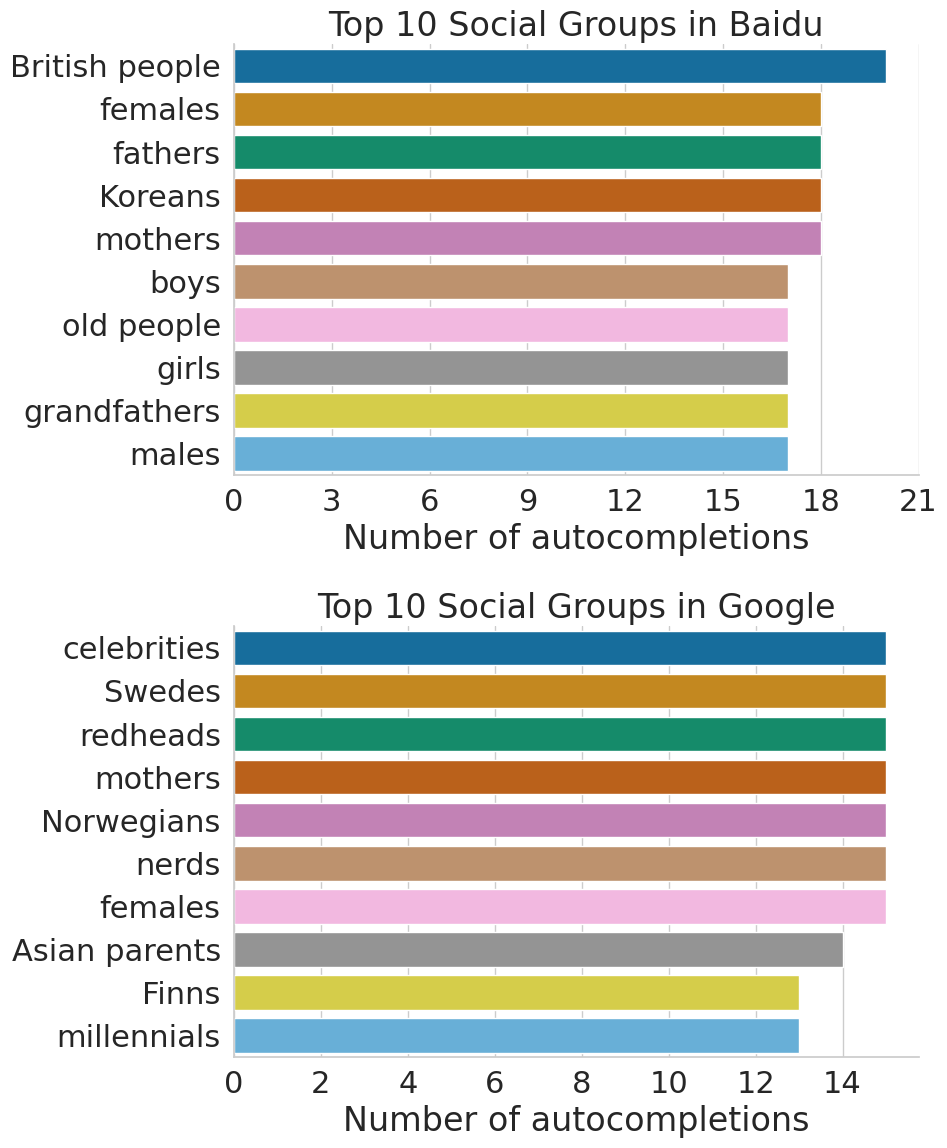

In [87]:
# Revised function to create a more refined and flatter horizontal bar plot without borders
def create_refined_horizontal_bar_plot(data, title, ax):
    sns.barplot(x=data.values, y=data.index, palette=sns.color_palette("colorblind"), ax=ax)
    ax.set_title(title)
    ax.set_ylabel("")
    ax.set_xlabel('Number of autocompletions')
    ax.xaxis.set_major_locator(mtick.MaxNLocator(integer=True))
    sns.despine(ax=ax)  # Remove the top and right spines

# Create figure with two subplots for horizontal layout, adjusted for a flatter look
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))  # Adjusted size for a flatter appearance

# Plotting for Baidu
create_refined_horizontal_bar_plot(top_K_baidu, 'Top 10 Social Groups in Baidu', axes[0])

# Plotting for Google

create_refined_horizontal_bar_plot(top_K_google, 'Top 10 Social Groups in Google', axes[1])

plt.tight_layout()
plt.show()

fig.savefig("top_social_groups.pdf")

### unresponded query

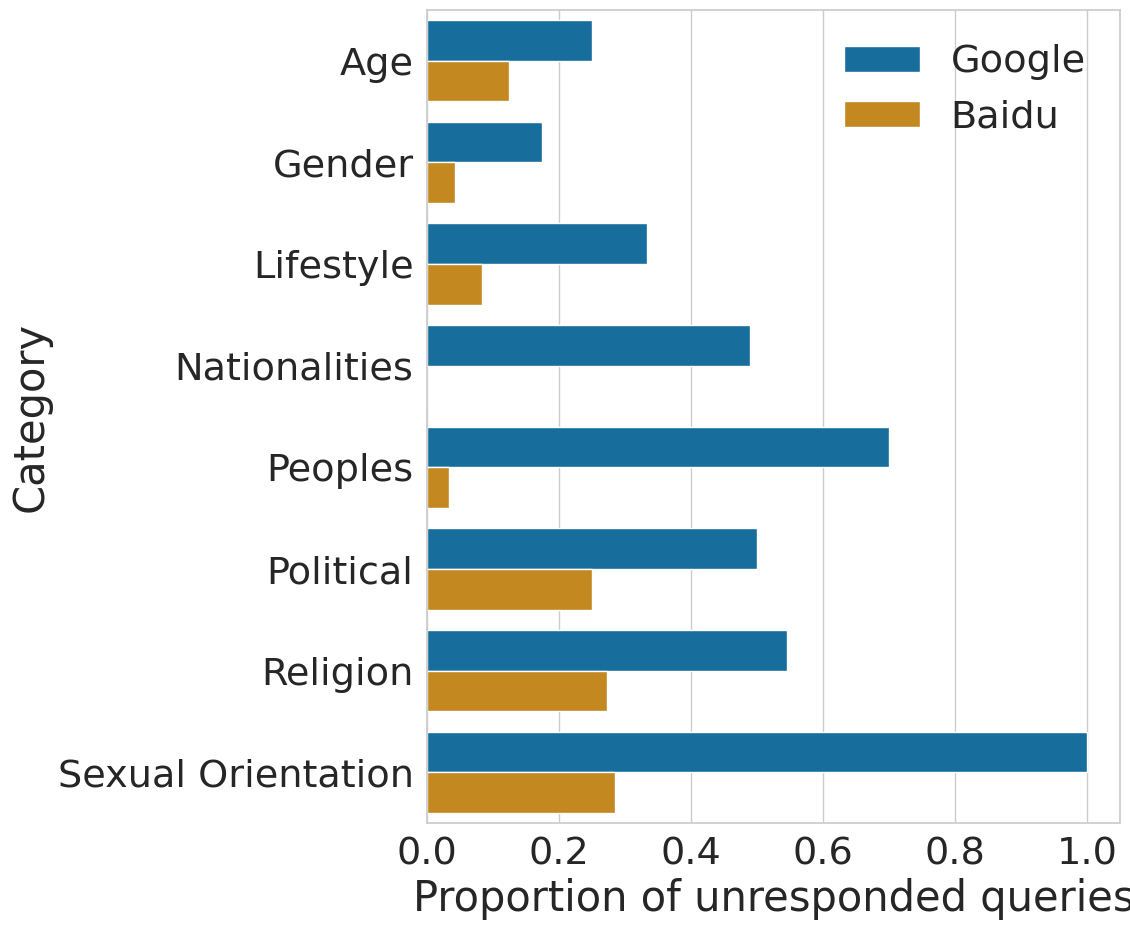

In [121]:
# Read in the data
baidu = pd.read_csv("data/baidu.csv").drop_duplicates(subset=['group_English'])
google = pd.read_csv("data/google.csv")

# Identifying unresponded queries for Google
unresponded_queries_google = google[google['suggestion'].isnull()]

# Identifying unresponded queries for Baidu 'Template 1'
# df_template_1 = baidu[baidu.template_match == "template 1"]
#unresponded_queries_baidu_template_1 = df_template_1[df_template_1['suggestion'].isna()]
unresponded_queries_baidu = baidu[baidu["suggestion"].isna()].drop_duplicates(subset=['group_English'])

# Calculating unresponded rates for Google and Baidu
def calculate_unresponded_rates(df, unresponded_df):
    unique_queries_per_category = df.groupby('category')['query'].nunique()
    unresponded_queries_per_category = unresponded_df.groupby('category').size()
    unresponded_rate_per_category = (unresponded_queries_per_category / unique_queries_per_category).fillna(0)
    return pd.DataFrame({
        'Total Unique Queries': unique_queries_per_category,
        'Unresponded Queries': unresponded_queries_per_category,
        'Unresponded Rate': unresponded_rate_per_category
    }).reset_index()

# Google and Baidu unresponded rates DataFrames
google_unresponded_rate_df = calculate_unresponded_rates(google, unresponded_queries_google)
baidu_unresponded_rate_df = calculate_unresponded_rates(baidu, unresponded_queries_baidu)

# Preparing the data for seaborn plot
google_unresponded_rate_df['Search Engine'] = 'Google'
baidu_unresponded_rate_df['Search Engine'] = 'Baidu'
combined_df = pd.concat([google_unresponded_rate_df, baidu_unresponded_rate_df])

# Plotting using seaborn
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(data=combined_df, x='Unresponded Rate', y='category', hue='Search Engine', palette='colorblind')
# plt.title('Unresponded Rate by Category in Google and Baidu "Template 1" (Color Blind Friendly)', fontsize=14)
plt.xlabel('Proportion of unresponded queries')
plt.ylabel('Category')
plt.tight_layout()
plt.legend(frameon=False)

fig.savefig("unresponded_proportion.pdf")

### no group in the suggestion
### changed format in the suggestion

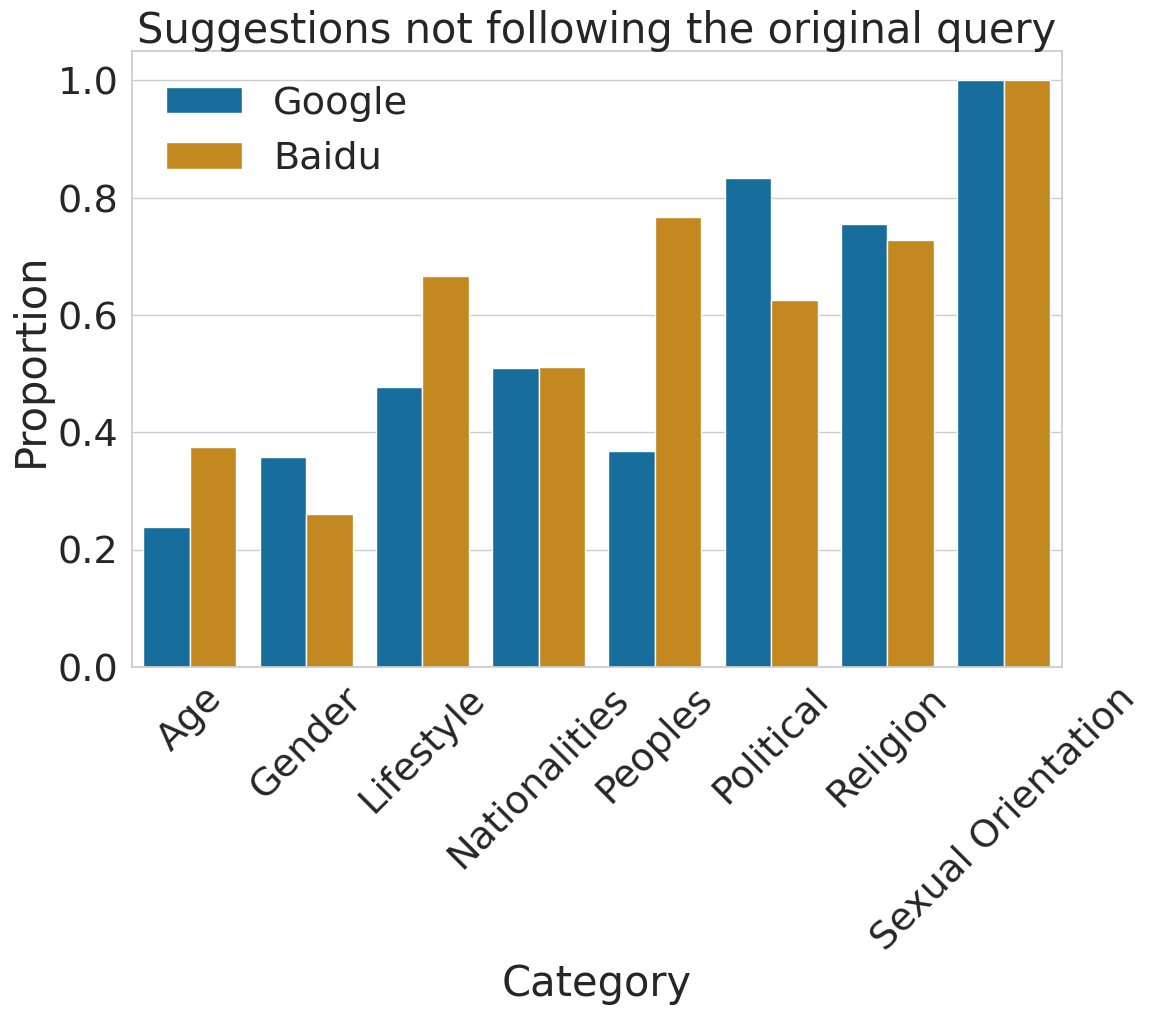

<Axes: title={'center': 'Suggestions not following the original query'}, xlabel='Category', ylabel='Not Contain Group %'>

In [143]:
# Read in the data
# baidu_template_1 = baidu[baidu.template_match == "template 1"]
# baidu_template_2 = baidu[baidu.template_match == "template 2"]
google = pd.read_csv("data/google.csv")
baidu = pd.read_csv("data/baidu.csv").drop_duplicates(subset=['group_English'])

# Step 5: Calculate Inverse Proportions for Each Category
def calculate_category_inverse_proportions(grouped_data):
    proportions = {}
    for category, group in grouped_data:
        total = len(group)
        not_follow_query = (total - group['suggestion_starts_with_query'].sum()) / total
        not_contain_group = (total - group['group_in_suggestion'].sum()) / total
        proportions[category] = {'Not Follow Query': group['suggestion_starts_with_query'].sum(), 
                                 'Not Contain Group': group['group_in_suggestion'].sum(),
            'Not Follow Query %': not_follow_query, 'Not Contain Group %': not_contain_group}
    return proportions

# Group the data by category for each template and search engine
# grouped_baidu_template_1 = baidu_template_1.groupby('category')
# grouped_baidu_template_2 = baidu_template_2.groupby('category')
grouped_baidu = baidu.groupby("category")
grouped_google = google.groupby('category')

# Calculate the inverse proportions
inverse_proportions_baidu = calculate_category_inverse_proportions(grouped_baidu)
# inverse_proportions_baidu_template_2 = calculate_category_inverse_proportions(grouped_baidu_template_2)
inverse_proportions_google = calculate_category_inverse_proportions(grouped_google)

# Prepare the data for plotting
plot_data = []
for category in inverse_proportions_baidu:
    plot_data.append({
        'Category': category,
        'Template': 'Baidu',
        'Not Follow Query': inverse_proportions_baidu[category]['Not Follow Query'],
        'Not Contain Group': inverse_proportions_baidu[category]['Not Contain Group'],
        'Not Follow Query %': inverse_proportions_baidu[category]['Not Follow Query %'],
        'Not Contain Group %': inverse_proportions_baidu[category]['Not Contain Group %']
    })

for category in inverse_proportions_google:
    plot_data.append({
        'Category': category,
        'Template': 'Google',
        'Not Follow Query': inverse_proportions_google[category]['Not Follow Query'],
        'Not Contain Group': inverse_proportions_google[category]['Not Contain Group'],
        'Not Follow Query %': inverse_proportions_google[category]['Not Follow Query %'],
        'Not Contain Group %': inverse_proportions_google[category]['Not Contain Group %']
    })

df_plot = pd.DataFrame(plot_data)

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='Category', y='Not Follow Query %', hue='Template', hue_order=["Google", "Baidu"], data=df_plot, ax=ax, palette='colorblind')
plt.title('Suggestions not following the original query')
plt.ylabel('Proportion')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.legend(frameon=False)
plt.show()

sns.barplot(ax=ax, x='Category', y='Not Contain Group %', hue='Template', hue_order=["Google", "Baidu"], data=df_plot, palette='muted')
plt.title('Suggestions not containing the original group')
plt.ylabel('Proportion')
plt.xlabel('Category')
plt.xticks(rotation=45)
plt.legend(frameon=False)
plt.show()


# RQ2: What is the sentiment of search engine completion on Google vs Baidu?

In [48]:
## dataframe {engine, category, group, % negative}

## sns.boxplot
## hue = engine
## x = category
## y = % negative

## kruskal-wallis test?

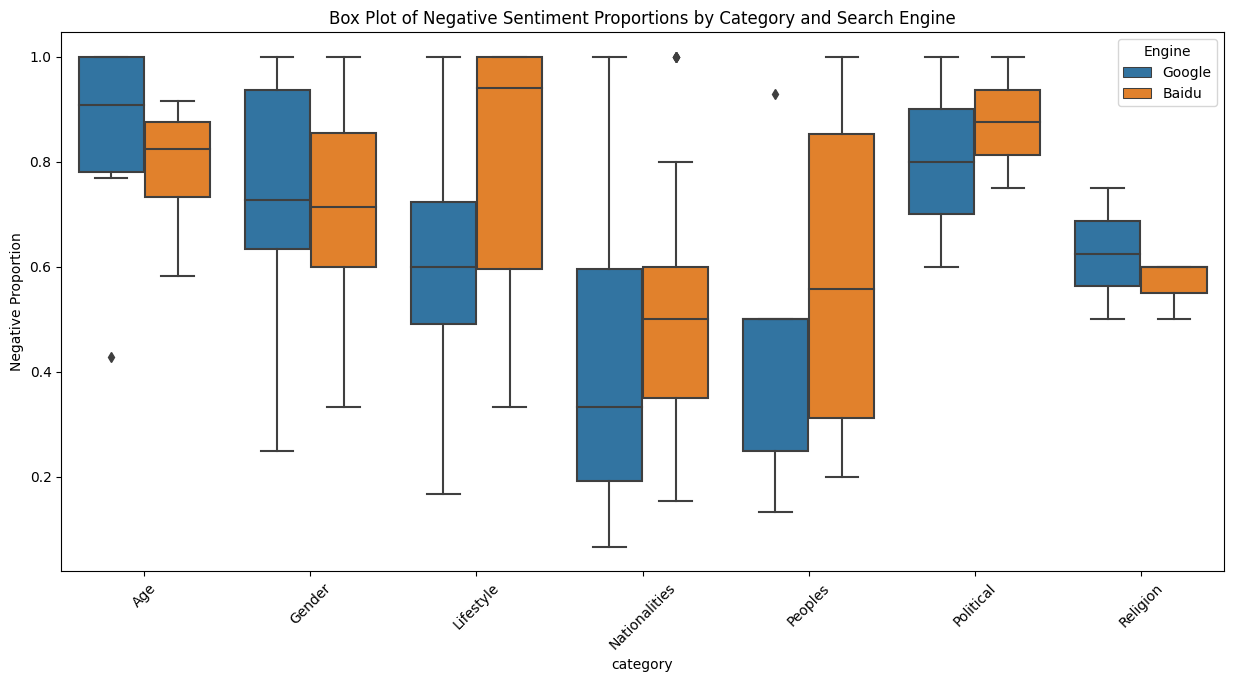

In [49]:
# Reading the files
google = pd.read_csv('data/google.csv')
baidu = pd.read_csv('data/baidu.csv')

baidu['suggestion_starts_with_query'].fillna(False, inplace=True)
google['suggestion_starts_with_query'].fillna(False, inplace=True)
baidu_start_with_query = baidu[baidu['suggestion_starts_with_query']]
google_start_with_query = google[google['suggestion_starts_with_query']]
# remove duplicated data in the same group
baidu_start_with_query = baidu_start_with_query.drop_duplicates(subset=['group_English', 'completion'])
google_start_with_query = google_start_with_query.drop_duplicates(subset=['group', 'completion'])
# Calculating the negative proportion for all groups in both datasets
google_negative_proportions_all = google_start_with_query[google_start_with_query['sentiment_rating_completion'] == 'Negative'].groupby(['category', 'group']).size() / google_start_with_query.groupby(['category', 'group']).size()
baidu_negative_proportions_all = baidu_start_with_query [baidu_start_with_query ['sentiment_rating_completion'] == 'Negative'].groupby(['category', 'group_English']).size() / baidu_start_with_query.groupby(['category', 'group_English']).size()

# Resetting index to convert Series to DataFrame for plotting
google_negative_proportions_df = google_negative_proportions_all.reset_index(name='Negative Proportion')
baidu_negative_proportions_df = baidu_negative_proportions_all.reset_index(name='Negative Proportion')

# Renaming columns for Baidu data to match Google data
baidu_negative_proportions_df.rename(columns={'group_English': 'group'}, inplace=True)

# Adding a column to distinguish between Google and Baidu data
google_negative_proportions_df['Engine'] = 'Google'
baidu_negative_proportions_df['Engine'] = 'Baidu'

# Concatenating both dataframes
combined_data = pd.concat([google_negative_proportions_df, baidu_negative_proportions_df])

# Plotting the combined box plot with hue based on search engine
plt.figure(figsize=(15, 7))
sns.boxplot(data=combined_data, x='category', y='Negative Proportion', hue='Engine')
plt.title('Box Plot of Negative Sentiment Proportions by Category and Search Engine')
plt.xticks(rotation=45)
plt.show()


### kruskal-wallis test

In [50]:
# Filtering the data to include only the rows where there is a recorded negative proportion
filtered_google_data = google_negative_proportions_df[google_negative_proportions_df['Negative Proportion'].notna()]
filtered_baidu_data = baidu_negative_proportions_df[baidu_negative_proportions_df['Negative Proportion'].notna()]

# Performing the Kruskal-Wallis test for each category
categories = combined_data['category'].unique()
kruskal_results = {}

for category in categories:
    google_data_cat = filtered_google_data[filtered_google_data['category'] == category]['Negative Proportion']
    baidu_data_cat = filtered_baidu_data[filtered_baidu_data['category'] == category]['Negative Proportion']
    
    # Perform Kruskal-Wallis test if both Google and Baidu have data for the category
    if not google_data_cat.empty and not baidu_data_cat.empty:
        stat, p = kruskal(google_data_cat, baidu_data_cat)
        kruskal_results[category] = {'statistic': stat, 'p-value': p}

kruskal_results

{'Age': {'statistic': 0.5432098765432152, 'p-value': 0.46110548552542374},
 'Gender': {'statistic': 0.08829329259825308, 'p-value': 0.7663581973172011},
 'Lifestyle': {'statistic': 1.3834459459459474,
  'p-value': 0.23951504841271173},
 'Nationalities': {'statistic': 1.8206068354420293,
  'p-value': 0.1772410604486706},
 'Peoples': {'statistic': 0.26395027624309675, 'p-value': 0.6074191583640334},
 'Political': {'statistic': 0.16666666666666508,
  'p-value': 0.6830913983096101},
 'Religion': {'statistic': 0.09259259259259127, 'p-value': 0.7609067270751158}}

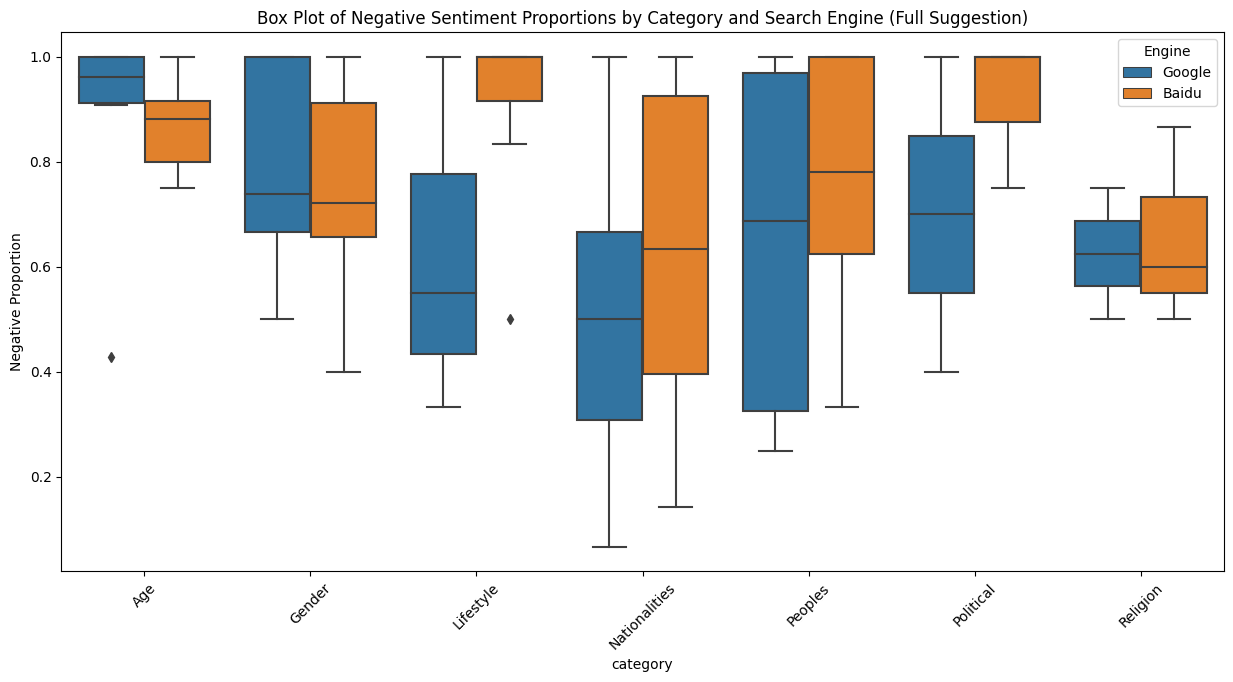

{'Age': {'statistic': 1.0563492063492133, 'p-value': 0.3040493256791847},
 'Gender': {'statistic': 0.2912673341543157, 'p-value': 0.5894095351179598},
 'Lifestyle': {'statistic': 5.176864244741869, 'p-value': 0.02288959733750166},
 'Nationalities': {'statistic': 2.5814922226173476,
  'p-value': 0.10811969282426268},
 'Peoples': {'statistic': 0.35383064516128887, 'p-value': 0.5519526636899947},
 'Political': {'statistic': 0.4166666666666696, 'p-value': 0.5186050164287239},
 'Religion': {'statistic': 0.0877192982456128, 'p-value': 0.7670968684102789}}

In [51]:



# Filtering the data for the 'Sentiment Rating (Full Suggestion)' column
google_full_suggestion_negative = google_start_with_query[google_start_with_query['sentiment_rating_full_suggestion'] == 'Negative'].groupby(['category', 'group']).size() / google_start_with_query.groupby(['category', 'group']).size()
baidu_full_suggestion_negative = baidu_start_with_query[baidu_start_with_query['sentiment_rating_full_suggestion'] == 'Negative'].groupby(['category', 'group_English']).size() / baidu_start_with_query.groupby(['category', 'group_English']).size()

# Resetting index to convert Series to DataFrame for plotting
google_full_suggestion_negative_df = google_full_suggestion_negative.reset_index(name='Negative Proportion')
baidu_full_suggestion_negative_df = baidu_full_suggestion_negative.reset_index(name='Negative Proportion')

# Renaming columns for Baidu data to match Google data
baidu_full_suggestion_negative_df.rename(columns={'group_English': 'group'}, inplace=True)

# Adding a column to distinguish between Google and Baidu data
google_full_suggestion_negative_df['Engine'] = 'Google'
baidu_full_suggestion_negative_df['Engine'] = 'Baidu'

# Concatenating both dataframes
combined_full_suggestion_data = pd.concat([google_full_suggestion_negative_df, baidu_full_suggestion_negative_df])

# Plotting the combined box plot with hue based on search engine
plt.figure(figsize=(15, 7))
sns.boxplot(data=combined_full_suggestion_data, x='category', y='Negative Proportion', hue='Engine')
plt.title('Box Plot of Negative Sentiment Proportions by Category and Search Engine (Full Suggestion)')
plt.xticks(rotation=45)
plt.show()

# Preparing the data for Kruskal-Wallis test (Full Suggestion)
filtered_google_full_suggestion_data = google_full_suggestion_negative_df[google_full_suggestion_negative_df['Negative Proportion'].notna()]
filtered_baidu_full_suggestion_data = baidu_full_suggestion_negative_df[baidu_full_suggestion_negative_df['Negative Proportion'].notna()]

# Performing the Kruskal-Wallis test for each category (Full Suggestion)
kruskal_results_full_suggestion = {}

for category in categories:
    google_data_cat_full = filtered_google_full_suggestion_data[filtered_google_full_suggestion_data['category'] == category]['Negative Proportion']
    baidu_data_cat_full = filtered_baidu_full_suggestion_data[filtered_baidu_full_suggestion_data['category'] == category]['Negative Proportion']
    
    # Perform Kruskal-Wallis test if both Google and Baidu have data for the category
    if not google_data_cat_full.empty and not baidu_data_cat_full.empty:
        stat, p = kruskal(google_data_cat_full, baidu_data_cat_full)
        kruskal_results_full_suggestion[category] = {'statistic': stat, 'p-value': p}

kruskal_results_full_suggestion

